# Supplemental Materials
s1873546

## 1. Setup

### 1.1 Libraries

In [38]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn
import sklearn
# sklearn preprocessing
from sklearn.preprocessing import LabelEncoder, scale
# sklearn support vector machines
from sklearn.svm import SVC, LinearSVC
# sklearn metrics
from sklearn.metrics import classification_report

### 1.2 Data

In [39]:
wine_train = pd.read_csv("wine_qual_train.csv")
wine_test  = pd.read_csv("wine_qual_test.csv")

In [60]:
print("The number of missing values in the data is:", sum(wine_train.isnull().sum()))

The number of missing values in the data is: 0


In [61]:
wine_train.shape

(3000, 13)

## Preprocessing

In [40]:
def preprocessing(data, scaled=True):
    '''
    Does some preprocessing on the data
    Input:
    - pd.DataFrame on which we will perform the pre-processing
    - A boolean 'scaled' to indicate whether we want to scale the data
    Output:
    - pd.DataFrame X containing the features we want to model
    - Quality score column y
    '''
    
    # Make a copy of the data to keep the original data untouched
    X = data.copy()
    
    # log-transform the skewed data
    X['log_sulphates'] = np.log(X['sulphates'])
    X['log_density'] = np.log(X['density'])
    X['log_residual_sugar'] = np.log(X['residual_sugar'])
    X['log_volatile_acidity'] = np.log(X['volatile_acidity'])
    X['log_fixed_acidity'] = np.log(X['fixed_acidity'])
    X['log_residual_sugar'] = np.log(X['residual_sugar'])
    X['log_chlorides'] = np.log(X['chlorides'])
    X['log_free_sulfur_dioxide'] = np.log(X['free_sulfur_dioxide'])
    
    # Change white wine to 0 and red wine to 1
    X['wine'] = X['wine'].apply(lambda x: 0 if x == "white" else 1)
    
    # discretizing the quality parameter
    X['quality_cat'] = pd.cut(x=X['quality'], bins=[0, 4, 5, 6, 10], 
               labels=['0_Poor', '1_Average', '2_Good', '3_Excellent'])
    
    # set y to be the quality parameter
    y = X['quality_cat']
    
    # drop the non-log transformed columns and the quality-related columns
    X = X.drop(columns = ['sulphates', 'density', 'residual_sugar',
                          'fixed_acidity','residual_sugar', 'chlorides',
                          'free_sulfur_dioxide', 'quality', 'quality_cat'])
    
    # Scale the data if desired
    if scaled == True:
        X = X.apply(scale)
    
    return X, y

In [41]:
# training data
X, y = preprocessing(wine_train)                     

# test data
X_test, y_test = preprocessing(wine_test)

### Logistic Regression

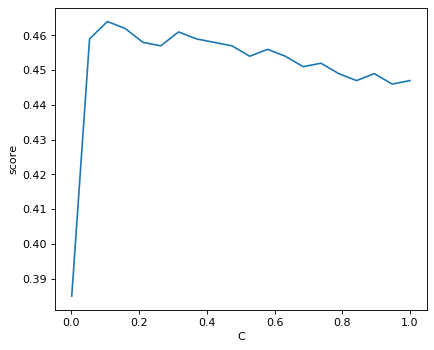

-----------------------------------------------------------
[[177  26  46  76]
 [ 19 130  39  14]
 [104 139 121  65]
 [ 10   3   4  27]]
-----------------------------------------------------------
              precision    recall  f1-score   support

     Average       0.57      0.54      0.56       325
   Excellent       0.44      0.64      0.52       202
        Good       0.58      0.28      0.38       429
        Poor       0.15      0.61      0.24        44

    accuracy                           0.46      1000
   macro avg       0.43      0.52      0.42      1000
weighted avg       0.53      0.46      0.46      1000



In [26]:
Cs = np.linspace(0.001, 1, 20)
res = np.zeros(20)
i=0
for C in Cs:
    m = LogisticRegression(multi_class='multinomial', 
                           C=C, 
                           max_iter=10_000,
                           class_weight='balanced'
                          ).fit(X, y)
    res[i] = m.score(X_test, y_test)
    i+=1
plt.plot(Cs, res)
plt.xlabel('C')
plt.ylabel('score')
plt.show()

m_log = LogisticRegression(multi_class='multinomial',  
                           C=0.5, 
                           max_iter=10_000,
                           class_weight='balanced'
                          ).fit(X, y)
print('-----------------------------------------------------------')
print(confusion_matrix(y_test, m_log.predict(X_test)))
print('-----------------------------------------------------------')
print(classification_report(y_test, m_log.predict(X_test)))

### Decision Tree Classfier

In [ ]:
m_tree = GridSearchCV(
     DecisionTreeClassifier(),
     param_grid={'criterion': ['gini', 'entropy'], 
                 'splitter': ['best', 'random'],
                 'max_depth': range(3, 15),
                 'min_samples_split': range(2, 10),
                 'min_samples_leaf': range(1, 10)},   
    scoring='f1_weighted'
).fit(X, y)

print(m_tree.best_params_)
print('-----------------------------------------------------------')
print(confusion_matrix(y_test, m_tree.predict(X_test)))
print('-----------------------------------------------------------')
print(classification_report(y_test, m_tree.predict(X_test)))

### Random Forest Classifier

In [21]:
m_forest = GridSearchCV(
     RandomForestClassifier(),
     param_grid={'n_estimators': range(50, 250, 50),
                 'criterion': ['gini', 'entropy'],
                 'max_depth': range(13, 18)}
).fit(X, y)

print(m_forest.score(X_test, y_test))
print(m_forest.best_params_)
print('-----------------------------------------------------------')
print(confusion_matrix(y_test, m_forest.predict(X_test)))
print('-----------------------------------------------------------')
print(classification_report(y_test, m_forest.predict(X_test)))

0.646
{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 200}
-----------------------------------------------------------
[[231   6  88   0]
 [ 10  84 108   0]
 [ 81  20 328   0]
 [ 22   0  19   3]]
-----------------------------------------------------------
              precision    recall  f1-score   support

     Average       0.67      0.71      0.69       325
   Excellent       0.76      0.42      0.54       202
        Good       0.60      0.76      0.67       429
        Poor       1.00      0.07      0.13        44

    accuracy                           0.65      1000
   macro avg       0.76      0.49      0.51      1000
weighted avg       0.68      0.65      0.63      1000



### K Neighbors

In [ ]:
m_neigh = GridSearchCV(
     KNeighborsClassifier(),
     param_grid={'n_neighbors': range(10, 20),
                 'leaf_size': range(20, 40, 5),
                 'weights': ['uniform', 'distance'],
                 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
    scoring='accuracy'
).fit(X_scaled, y)

print('-----------------------------------------------------------')
print(confusion_matrix(y_test, m_neigh.predict(X_test_scaled)))
print('-----------------------------------------------------------')
print(classification_report(y_test, m_neigh.predict(X_test_scaled)))